# Advanced Lane Finding Project

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [29]:
#importing some useful packages

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob # glob API for importing list of (calibration) images
#from cal_undistort import cal_undistort

## Camera calibration using chessboard images

In [30]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # nx=9 and ny=6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

"""
img = plt.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
"""

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') # importing the glob API

# print(images[0]) # DEBUG

# Step through the list and search for chessboard corners and if found, add object and image points (needed later in cv.calibrateCamera())
for fname in images:
    img = plt.imread(fname)
    # no cv2.undistort(img, mtx, dist, None) here because cal images are not distorted (only the first one a little bit maybe)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # why? to find corners easily in the next step
                                                # if you are using cv2.imread() or the glob API, as happens here,
                                                # this will read in a BGR image and you should convert to grayscale
                                                # using cv2.COLOR_BGR2GRAY.

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # nx=9 and ny=6 (ret=return)

    # If found, add object points, image points
    if ret == True:
        #print(objp) #DEBUG
        objpoints.append(objp) # für jedes Bild in der for-Schleife wird dasselbe array (objp) hinzugefügt
        imgpoints.append(corners)

        # Draw and display the corners (this is not necessary but helpful for demonstration purposes)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
print(mtx)
print(dist)

[[1.15660657e+03 0.00000000e+00 6.68965538e+02]
 [0.00000000e+00 1.15164193e+03 3.88052526e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.23184586 -0.11837233 -0.0011656   0.00023915  0.15365722]]


## Helper functions (for both pipelines)

In [31]:
from helper_functions import cal_undistort

## Pipeline (test images)

### Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


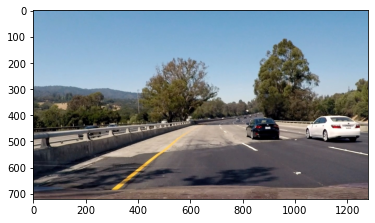

In [32]:
#reading in an image
img = mpimg.imread('test_images/test4.jpg')

# ATTENTION: If you are using cv2.imread() or the glob API, this will read in a BGR image and you should convert to grayscale
# (in later image processing steps) using cv2.COLOR_BGR2GRAY.

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)  # single color channel image, e.g. gray , call as plt.imshow(gray, cmap='gray')

### Distortion correction

In [33]:
undistorted = cal_undistort(img, objpoints, imgpoints, mtx, dist)
plt.imshow(undistorted)

TypeError: cal_undistort() takes 3 positional arguments but 5 were given

## Pipeline (video)

In [34]:
import os #This module provides a portable way of using operating system dependent functionality.
os.listdir("test_images/")

['signs_vehicles_xygrad.png',
 'straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 3) # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally

    #canny
    low_threshold = 80
    high_threshold = 220
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Select a region of interest
    # the origin (x=0, y=0) is in the upper left
    left_bottom = np.array([0, 539])
    right_bottom = np.array([900, 539])
    apex = np.array([500, 310])
    vertices = np.array([left_bottom, right_bottom, apex])
    masked_edges = region_of_interest(edges, [vertices])
    
    # Define the Hough transform parameters and apply
    rho = 1 # units of pixels
    theta = np.pi/180 # units of radians
    threshold = 3 # minimum number of intersections a candidate line needs to have to make it into the output
    min_line_len = 5 # minimum length of a line (in pixels) that you will accept in the output
    max_line_gap = 3 # maximum distance (in pixels) between segments that you will allow to be connected into a single line
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # a blank image (all black) with lines drawn on it.

    # combine the line_image with the initial image
    # The result image is computed as follows: initial_img * α + img * β + γ; NOTE: initial_img and img must be the same shape!
    combo = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return combo

Testing on a video:

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so .subclip(start_second,end_second) was added
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline:

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Issues Discussion

### Description of Problems

### Solutions to the problems